In [1]:
CLUSTER_TYPE ='docker_cluster'
%env CLUSTER_TYPE $CLUSTER_TYPE
from dask.distributed import Client
client = Client('dask-scheduler:8786')
client

env: CLUSTER_TYPE=docker_cluster


<Client: 'tcp://172.26.0.2:8786' processes=8 threads=16, memory=7.63 GiB>

In [3]:
num_workers = 8

In [4]:
from time import time

from multiprocessing import cpu_count

import numpy as np
import pandas as pd
import sklearn.datasets
import matplotlib.pyplot as plt

import dask
import dask.array as da
import dask.dataframe as dd
from dask import compute
from dask import delayed
from dask.distributed import wait

import dask_ml.datasets
import dask_ml.cluster

import sklearn.cluster
##from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score
#from sklearn.utils.extmath import squared_norm

# Utils

In [5]:
#we want to work with dask array, hence we trasform everything to dask arrays
def make_da(X):
        if isinstance(X, dd.DataFrame):
            X = X.to_dask_array(lengths=True)
            
        if isinstance(X, da.core.Array): 
            return X
        
        else: raise ValueError("input is neither a dask array nor a dask dataframe")
        return X

In [6]:
def squared_euclidean_distance(x_i, x_j):
    diff= x_i-x_j
    return da.dot(diff, diff.T)

In [113]:
# we need to parallelize sklearn.metrics.pairwise_distances. 
# I didn't really did a general code as the one of sklearn.metrics.pairwise_distances but I directly compute the min
#distance of each point from the centroids and sum over all points 

'''def min_distance_point_from_set(point, Set):
    dist=[]
    for n in range(len(Set)):
        dist.append(delayed(squared_euclidean_distance)(point, Set[n]))
    min_dist=delayed(min)(dist)
    return min_dist '''
# we only compute when we call compute(evaluate_cost(...))

def new_centroid():
    

def evaluate_cost(X, centroids):
    # (da.Array, np.array) -> float
    
    distances_matrix = dask_ml.metrics.pairwise_distances(X, centroids) 
    tot = da.power(distances_matrix.min(axis=1), 2).sum()
    return tot

# Scalable K-means: K-means||

### Obeservation:
- Since the first centroid is random, it is a good choice to choose the first point of our dataset
- The centroids should be a numpy array stored in the machine. This way we can calculate distances without having to move data accross the nodes. This would have happened if the centroids array was distributed throughout the nodes.

In [90]:
def k_means_scalable(X, k, l):
    X=make_da(X)
    n = X.shape[0] #we don't have to compute to get the shape
    idx = np.random.randint(0, n)
    centroids = da.compute(X[idx, np.newaxis])[0] #since we computed it, it is a numpy array stored here, not on nodes.
    inital_cost = evaluate_cost(X ,centroids).compute()
    iterations = 0

    return inital_cost
    #c_idx = {idx}
    #(cost,) = compute(evaluate_cost(X, centers))

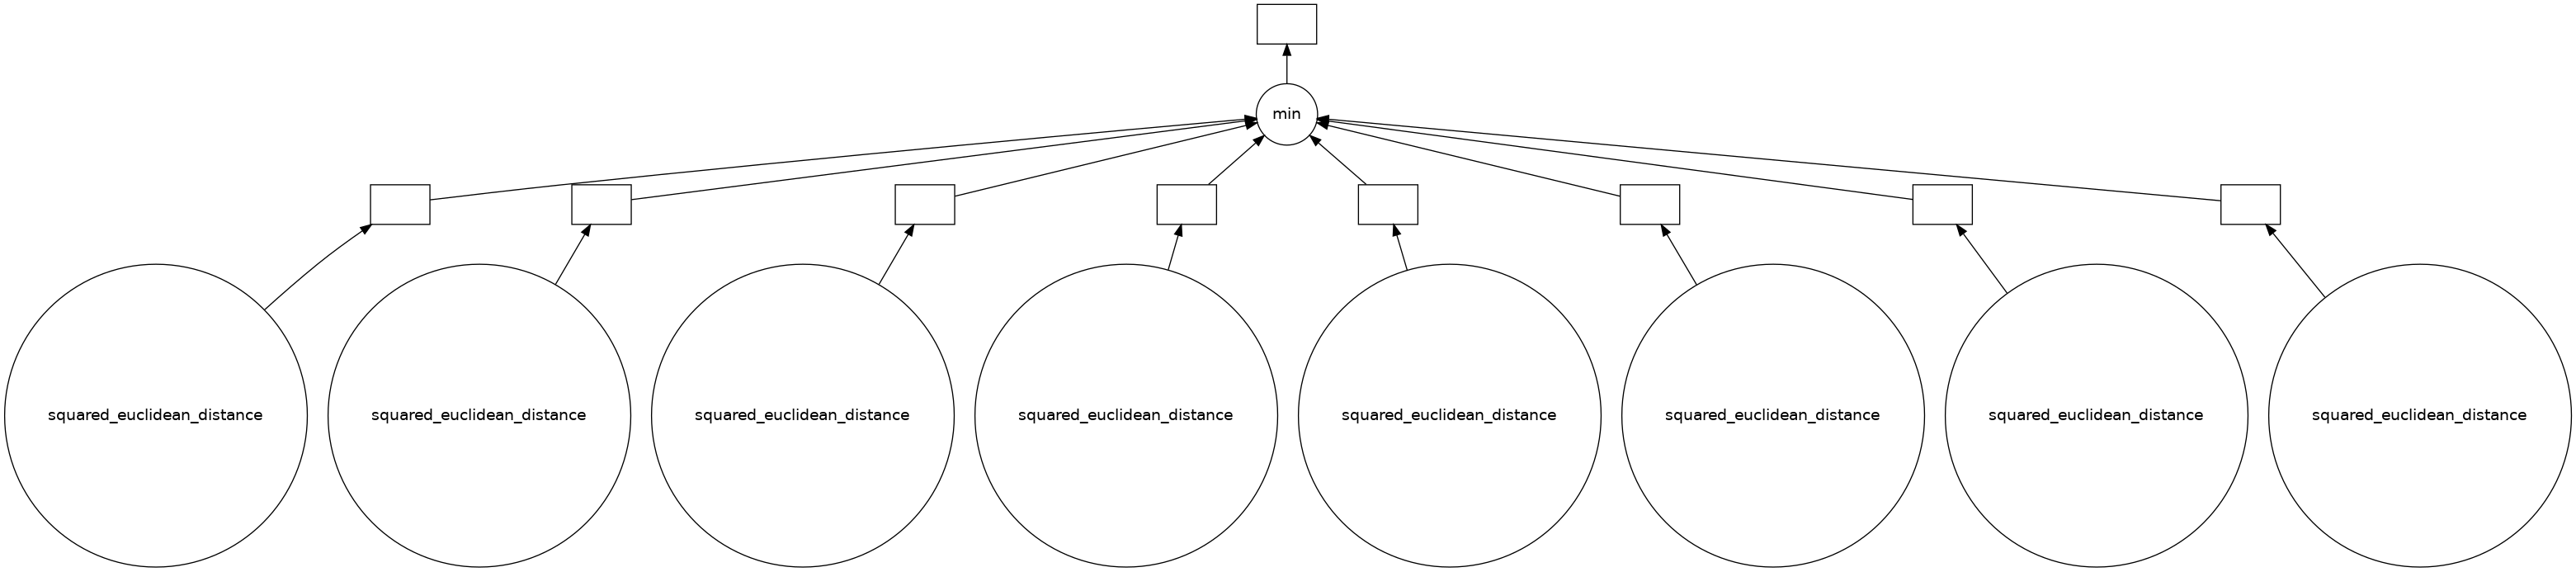

In [9]:
min_distance_point_from_set(1, [0, 1, 0 , 0 ,0 ,0 ,0 ,0]).visualize()

In [72]:
x=np.array([[1,2],[3, 4]])
y = np.array([5, 6])
np.vstack((x[0, np.newaxis][0], y))


array([[1, 2],
       [5, 6]])

In [84]:
X, y = dask_ml.datasets.make_blobs(10, centers=5, chunks=num_workers)

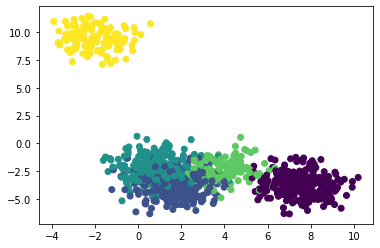

In [11]:
import matplotlib.pyplot as plt
plt.scatter(X[:,0], X[:,1], c=y)

In [12]:
X.persist()

dask.array<concatenate, shape=(1000, 2), dtype=float64, chunksize=(8, 2), chunktype=numpy.ndarray>

In [80]:
test = k_means_scalable(X, 5, 1)


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.94104 to fit


In [78]:
test

72697.32575449006

In [100]:
X[0].compute()

array([ 1.72235346, -5.81425711])

In [114]:
evaluate_cost(X , [[1, 2], [3,4]])

[[ 7.84757343  9.89707145]
 [11.2132709  13.00767312]
 [ 8.87066361 10.96448983]
 [ 9.06306998 10.70139425]
 [ 7.65468958  9.94429159]
 [ 9.4898869  11.60061647]
 [ 5.67067209  6.06140288]
 [ 4.45610864  4.90660692]
 [ 6.13028445  7.19471728]
 [10.49737996 12.62211621]]
[ 61.58440873 125.73744419  78.68867288  82.13923747  58.59427254
  90.05795345  32.156522    19.85690419  37.58038746 110.19498597]


dask.array<power, shape=(10,), dtype=float64, chunksize=(8,), chunktype=numpy.ndarray>